In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from tqdm import tqdm
from PIL import Image
#from IPython.display import Image
#from IPython.core.display import HTML 


In [2]:
class Picture_decomposition:
    '''
    Класс для работы с изображениями
    '''
    
    def __init__(self, path_name, pics_name, pic_size):
        self.path_name = path_name
        self.pics_name = pics_name
        self.pic_size = pic_size
        self.num_pics = None
        
        
    # пути всех файлов с именем 00000x.jpg
    # также тут устанавливаем их кол-во
    
    def get_pics_paths(self):
        path_list = []
        
        for path, subdirs, files in os.walk(self.path_name):
            for name in files:
                if name.endswith(self.pics_name):
                    path_list.append(os.path.join(path, name))
                    
        self.num_pics = len(path_list)
        
        return path_list
    
    # берем все пикчи с именем 00000x.jpg, ресайзим их до 50*50, и получившиеся 50*50*3 представления кладем в 
    # массив 
    
    def get_pics(self):
        path_list = self.get_pics_paths()
        pics_list = []
        
        for path in path_list:
            pic = Image.open(path)
            # ресайз кстати можно
            pic = pic.resize((self.pic_size, self.pic_size))
            pics_list.append(np.array(pic))
            pic.close()
            
        return np.array(pics_list)
        
    # выводим случайно выбранный пик из всех 00000x.jpg (ресайзнув предварительно)
    
    def get_random_pic(self, seed=1):
        path_list  = self.get_pics_paths()
        random_pic = random.Random(seed).choice(path_list)
        pic = Image.open(random_pic)
        pic = pic.resize((self.pic_size, self.pic_size))
        pic = np.array(pic)
        print(random_pic)
        plt.imshow(pic)
        
    # берем все пикчи 00000x.jpg, превращаем их в вектора и кладем их в одну матрицу S как столбцы
    
    def get_reshaped_pics(self):
        all_pics = self.get_pics()
        pics_reshaped = np.zeros((self.pic_size ** 2, len(all_pics), 3))
        
        for i, pic in enumerate(all_pics):
            for j in range(3):
                pics_reshaped[:, i, j] = pic[:,:,j].reshape(-1,1)[:,0]
        
        return pics_reshaped


    # считаем средний столбец в матрице S
    # + есть опция вывода: берем этот средний столбец, возвращаем его в вид 2d массива и выводим что получилось
    
    def get_mean_pic(self, show=False):
        all_pics_reshaped = self.get_reshaped_pics()
        mean_pic = np.mean(all_pics_reshaped, axis=1) # ДОБАВИТЬ ОПЦИЮ МЕДИАНЫ
        if show:  
            plt.imshow(mean_pic.reshape((self.pic_size, self.pic_size, 3)) / 256)
            
        return mean_pic
    
    # из каждого столбца матрицы S вычитаем средний столбец, получаем новую матрицу А
    
    def get_centered_pics(self):
        pics_reshaped = self.get_reshaped_pics()
        mean_pic = self.get_mean_pic()
        
        for i in range(self.num_pics):
            pics_reshaped[:,i,:] -= mean_pic
        
        return pics_reshaped
        
    # берем матрицу А. Превращаем ее в 3 матрицы по RGB и каждые 3 матрицы СВД раскладываем
    
    def compute_svd(self):
        centered_pics = self.get_centered_pics()
        ch_r = centered_pics[:,:,0]
        ch_g = centered_pics[:,:,1]
        ch_b = centered_pics[:,:,2]
        
        svd_r, svd_g, svd_b = np.linalg.svd(ch_r), np.linalg.svd(ch_g), np.linalg.svd(ch_b)
        
        return svd_r, svd_g, svd_b
    
    # Подсчет скалярных проекций на базовые лица для каждого вектор-лица
    
    def get_subspace_pics(self):
        
        pics_reshaped = self.get_reshaped_pics()
        mean_pic = self.get_mean_pic()
        centered_pics = self.get_centered_pics()
        
        dim = np.min((np.linalg.matrix_rank(centered_pics[:,:,0]), np.linalg.matrix_rank(centered_pics[:,:,1]),
                     np.linalg.matrix_rank(centered_pics[:,:,2])))
        
        svd_r, svd_g, svd_b = self.compute_svd()
        
        result = np.zeros((dim, self.num_pics, 3))
                
        for i in tqdm(range(self.num_pics)):
            result[:,i,0] = svd_r[0][:,:dim].T @ (pics_reshaped[:,i,0] - mean_pic[:,0])
            result[:,i,1] = svd_g[0][:,:dim].T @ (pics_reshaped[:,i,1] - mean_pic[:,1])
            result[:,i,2] = svd_b[0][:,:dim].T @ (pics_reshaped[:,i,2] - mean_pic[:,2])
        
        return result


# 1. Коллаж лиц из датасета

Показываем первые 25 лиц с названием 000001.jpg.

In [3]:
decomp = Picture_decomposition('dataset/CyberextruderUltimate/', '000001.jpg', 50)

In [4]:
pics = decomp.get_pics()

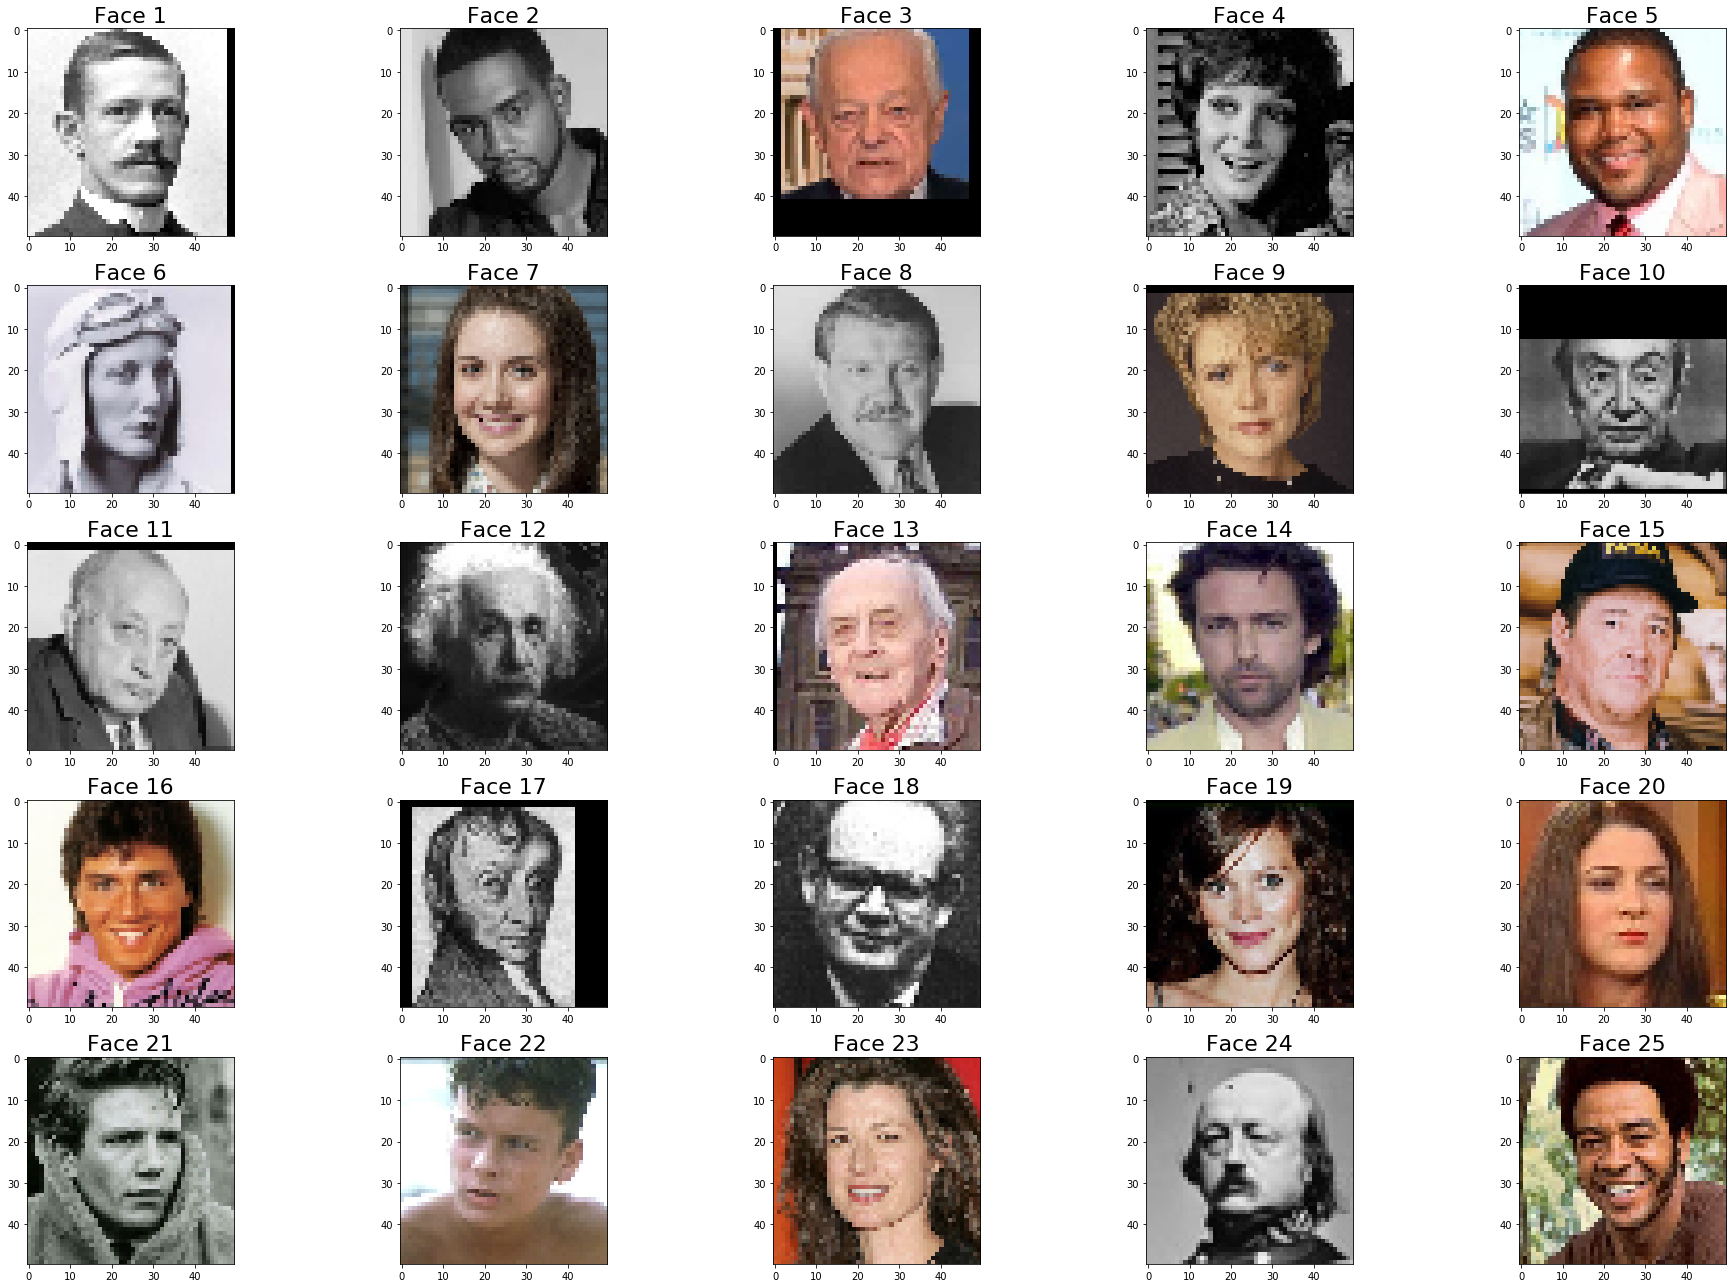

In [5]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(27, 18))

for i, ax in enumerate(axs.flat):
    
    ax.imshow(pics[i])    
    ax.set_title('Face %s' % (i+1), fontsize=22)

plt.tight_layout()
plt.show()

# 2. Коллаж после нормализации

Из каждого вектор-лица вычитаем средний вектор по всем лицам. Смотрим что будет на примере тех же первых 25 лицах.

In [6]:
normalized_pics = decomp.get_centered_pics()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

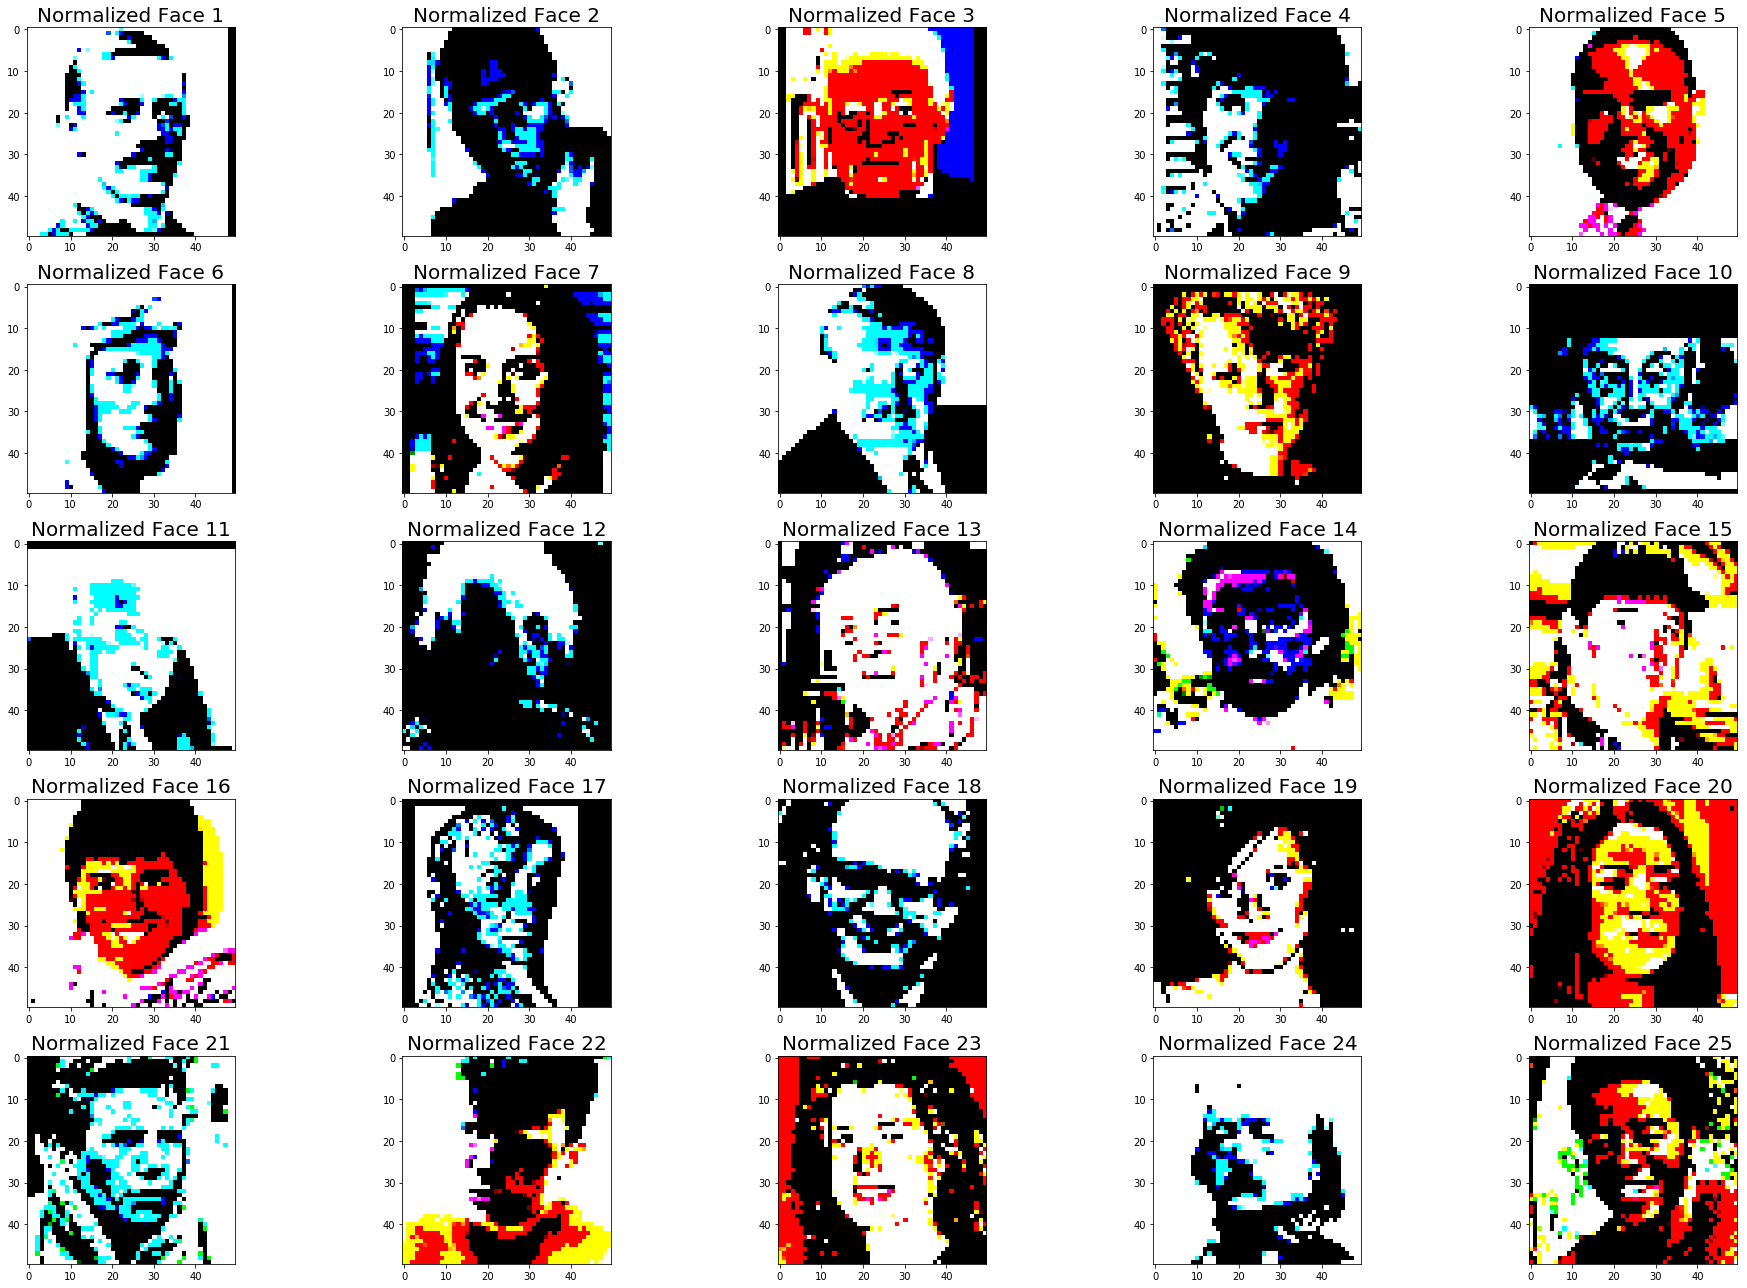

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(27, 18))

for i, ax in enumerate(axs.flat):
    
    ax.imshow(normalized_pics[:, i, :].reshape((decomp.pic_size, decomp.pic_size, 3)))    
    ax.set_title('Normalized Face %s' % (i+1), fontsize=20)

plt.tight_layout()
plt.show()

# 3. Усредненное лицо

При нормализации выше мы вычитали из каждого вектор-лица усредненное вектор-лицо. Посмотрим как это усредненное вектор-лицо выглядит.

In [8]:
mean_face = decomp.get_mean_pic()

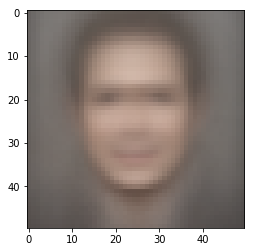

In [9]:
# тут astype(np.uint8) округляет интенсивности пикселей в целые числа

plt.imshow(mean_face.reshape((decomp.pic_size, decomp.pic_size, 3)).astype(np.uint8))

# 4. Базовые лица: вектора-столбцы матрицы U при SVD разложении

Нас интересуют только первые k столбцов U соответствующие самым большим сингулярным значениям.

In [10]:
r, g, b = decomp.compute_svd()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

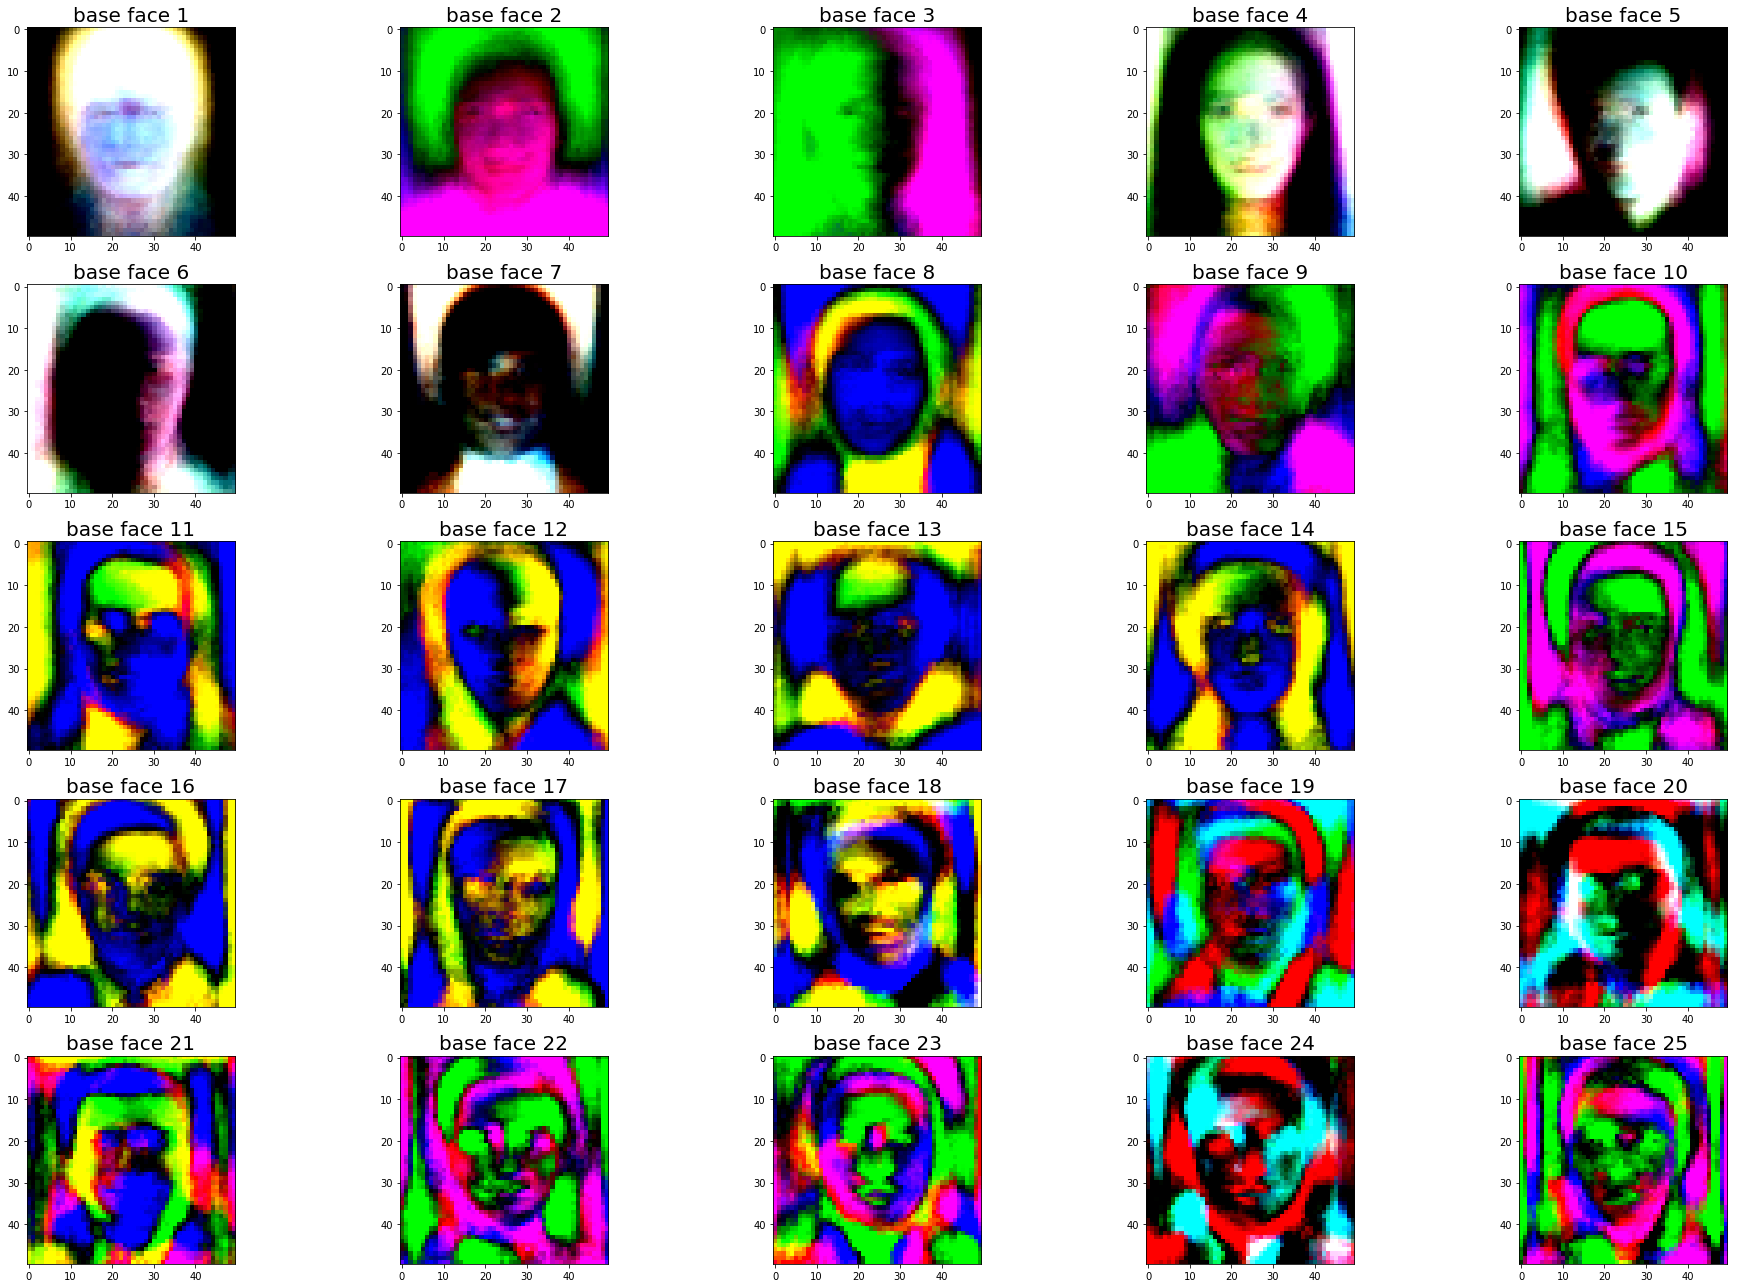

In [12]:
# Проблема при отображении: как линейно преобразовать интенсивность пикселей чтобы базовые лица были смотрибельны.
# Большая свобода выбора

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(27, 18))

for i, ax in enumerate(axs.flat, 1):
    
    
    base_face = (np.stack((r[0][:, i], g[0][:, i], b[0][:, i]), axis=1))*10
    ax.imshow(base_face.reshape((decomp.pic_size, decomp.pic_size, 3)) * 5)
    
    
    ax.set_title('base face %s' % i, fontsize=20)

plt.tight_layout()
plt.show()

# 5. Скалярные проекции вектор-лиц на базовые лица

In [14]:
# i-ый столбец проекция лица f_i

projections = decomp.get_subspace_pics()

100%|██████████| 1000/1000 [00:09<00:00, 101.22it/s]


# 6. Распознавание

1. Для начала выбираем случайное изображение (НЕОБЯЗАТЕЛЬНО ЛИЦО) (случайный каталог и в нем случайный файл). Надо будет добавить папку с НЕ лицами в директорию датасета.

In [33]:
random_catalog = random.sample(os.listdir('dataset/CyberextruderUltimate/'), 1)
random_catalog_path  = 'dataset/CyberextruderUltimate/' + random_catalog[0]

random_file = random.choice(os.listdir(random_catalog_path))
random_file_path = random_catalog_path + '/' + random_file

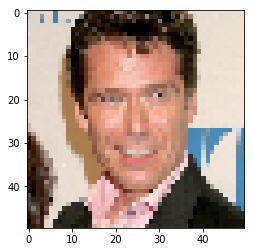

In [34]:
pic = Image.open(random_file_path)
pic = pic.resize((decomp.pic_size, decomp.pic_size))
pic = np.array(pic)
plt.imshow(pic)

In [41]:
# Изображение в вектор

pic_r = pic[:,:,0].reshape(-1,1)[:,0]
pic_g = pic[:,:,1].reshape(-1,1)[:,0]
pic_b = pic[:,:,2].reshape(-1,1)[:,0]

pic_vector = np.stack((pic_r, pic_g, pic_b), axis=1)

2. Cчитаем скалярную проекцию для выбранного изображения на базовые лица. Формула 13 из статьи.

In [22]:
dim = projections.shape[0]

In [45]:
pic_projection_r = r[0][:,:dim].T @ (pic_vector[:,0] - mean_face[:,0])
pic_projection_g = g[0][:,:dim].T @ (pic_vector[:,1] - mean_face[:,1])
pic_projection_b = b[0][:,:dim].T @ (pic_vector[:,2] - mean_face[:,2])

3. Считаем формулу 16 из статьи.

In [46]:
f_p_r = r[0][:,:dim] @ pic_projection_r
f_p_g = g[0][:,:dim] @ pic_projection_g
f_p_b = b[0][:,:dim] @ pic_projection_b

4. Расстояние нашего вектор-изображения до пространства лиц, формула 17. На три потока r,g,b.

In [50]:
e_f_r = np.linalg.norm((pic_vector[:,0] - mean_face[:,0]) - f_p_r)
e_f_g = np.linalg.norm((pic_vector[:,1] - mean_face[:,1]) - f_p_g)
e_f_b = np.linalg.norm((pic_vector[:,2] - mean_face[:,2]) - f_p_b)

In [52]:
# ТУТ НАДО УСТАНОВИТЬ ПОРОГ: ЕСЛИ e_f_(rgb) БОЛЬШЕ ПОРОГА, ТО ИЗОБР. НЕ ЛИЦО, ЕСЛИ НЕТ ТО ИЗОБРАЖЕНИЕ ЛИЦО
# И ДАЛЬШЕ МЫ ПОДБИРАЕМ НУЖНОЕ

5. Расстояние между координатами, формула 14.

In [65]:
ls = []

for i in range(projections.shape[1]):
    
    e_r = np.linalg.norm(projections[:,i,0] - pic_projection_r)
    e_g = np.linalg.norm(projections[:,i,1] - pic_projection_g)
    e_b = np.linalg.norm(projections[:,i,2] - pic_projection_b)
    
    # считаю сумму расстояний по трем цветам, м.б. надо делать чето поумнее
    threshold = e_r + e_g + e_b
    ls.append((i, threshold))

In [67]:
# Самые близкие лица к нашему. 

sorted(ls, key=lambda tup: tup[1])

[(481, 0.0),
 (419, 9901.361585626335),
 (789, 10054.415784430086),
 (743, 10663.457963732795),
 (105, 10670.454584767223),
 (720, 10812.349309120082),
 (65, 10862.81489097726),
 (482, 11007.467286914924),
 (613, 11079.240914041666),
 (906, 11178.50284372413),
 (281, 11215.395292130852),
 (669, 11233.762645964298),
 (553, 11326.604904069203),
 (326, 11327.58415703988),
 (987, 11373.151358573417),
 (849, 11393.004901689688),
 (31, 11411.622934926982),
 (194, 11444.224646897315),
 (89, 11465.97197038052),
 (268, 11482.902139793343),
 (884, 11504.75102295791),
 (934, 11526.73330060861),
 (836, 11543.928455759491),
 (491, 11558.502011520108),
 (486, 11561.320983735015),
 (660, 11568.99708289633),
 (517, 11605.624043501275),
 (195, 11625.383932354609),
 (39, 11628.675593013046),
 (388, 11631.64718357797),
 (829, 11632.862765139897),
 (924, 11662.670400874438),
 (915, 11682.94148056602),
 (75, 11688.020470033676),
 (111, 11698.33134774843),
 (986, 11766.206657381807),
 (813, 11783.4704751909

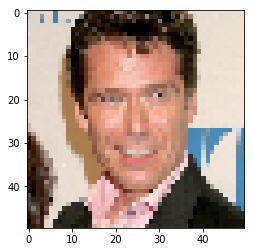

In [68]:
# Очевидно самым близким получилось тоже самое лицо

i = 481
plt.imshow(pics[i])

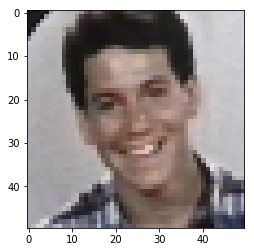

In [69]:
# Второе по близости

i = 419
plt.imshow(pics[i])